# Model X: 3D Dome structure

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

../../../gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


In [2]:
geo_data = gp.create_data([0,1000,0,1000,0,700],resolution=[50,50,35], 
                        path_o = "/home/fabian/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_modelx_orientations.csv", 
                        path_i = "/home/fabian/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_modelx_interfaces.csv")


In [3]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

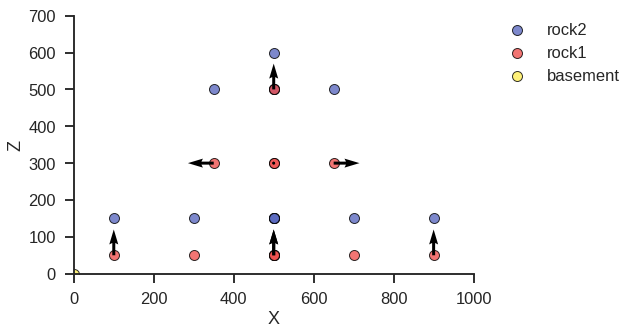

In [4]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [54]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

In [6]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [7]:
lith_block, fault_block = gp.compute_model(interp_data)

/home/fabian/miniconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


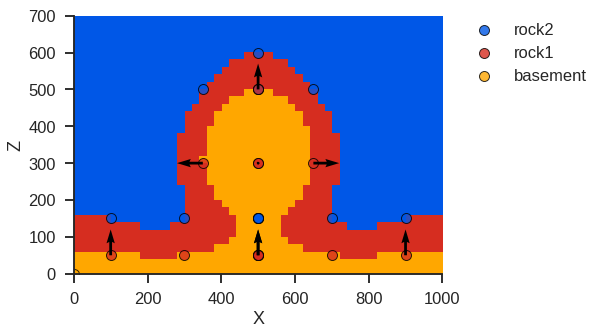

In [57]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=25,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Dome_model_res(50,50,35)_x', edgecolor='black', bbox_inches='tight')

In [9]:
import gempy.utils.Kriging_Jan as krige

In [10]:
d = {'X': [500, 500], 'Y': [500, 500], 'Z': [550,550], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X    Y    Z  Property
0  500  500  550        20
1  500  500  550        20


In [11]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='deformed_B', an_factor=100, var_par=(200,50,1))

initializing: 0.003902912139892578
Fault: False
10000
100
distance precalculation: 1006.5254821777344
submatrix extraction: 0.03386878967285156
distance Matrices: 1.7435657978057861
kriging calculation: 2.012744188308716
Negative Variances: 0
Out of: 14442


In [12]:
'''
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,600)
ax.axes.set_xlim3d(100,900)
ax.axes.set_ylim3d(100,900)
a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=100, marker=',', cmap='viridis', alpha=1)



fig.colorbar(a, orientation='horizontal')
'''

"\nfig = plt.figure(figsize=(14, 12))\nax = Axes3D(fig)\n\nax.axes.set_zlim3d(0,600)\nax.axes.set_xlim3d(100,900)\nax.axes.set_ylim3d(100,900)\na = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=100, marker=',', cmap='viridis', alpha=1)\n\n\n\nfig.colorbar(a, orientation='horizontal')\n"

In [59]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where((combined[:,1]<520) & (combined[:,1]>480))[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

combined_cut2 = np.where((combined[:,0]<520) & (combined[:,0]>480))[0]
combined_cut2 = combined[combined_cut2]
combined_cut2 = combined_cut2[:,[1,2,3]]

print(combined_cut.shape)
colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}

geo_data.set_colors(colormodel)

cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

geo_data.formations

(773, 3)


,value,formation_number,color
rock2,1,1,#BEBEBE
rock1,2,2,#A0A0A0
basement,3,3,#696969


In [14]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

In [81]:
# work on fix to plot over basement
lith_block_aux = np.round(lith_block)
aux_where = np.where(lith_block_aux[0] == 3)
coord_aux = geo_data.grid.values
coord_aux_aux = coord_aux[aux_where]
coord_aux_aux = coord_aux_aux[np.where((coord_aux_aux[:,1]>450)&(coord_aux_aux[:,1]<550))]

aux_where2 = np.where(lith_block_aux[0] == 1)
coord_aux2 = geo_data.grid.values
coord_aux_aux2 = coord_aux2[aux_where2]
coord_aux_aux2 = coord_aux_aux2[np.where((coord_aux_aux2[:,1]>450)&(coord_aux_aux2[:,1]<550))]

aux_where3 = np.where(lith_block_aux[0] == 1)
coord_aux3 = geo_data.grid.values
coord_aux_aux3 = coord_aux3[aux_where3]
coord_aux_aux3 = coord_aux_aux3[np.where((coord_aux_aux3[:,0]>450)&(coord_aux_aux3[:,0]<550))]


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  


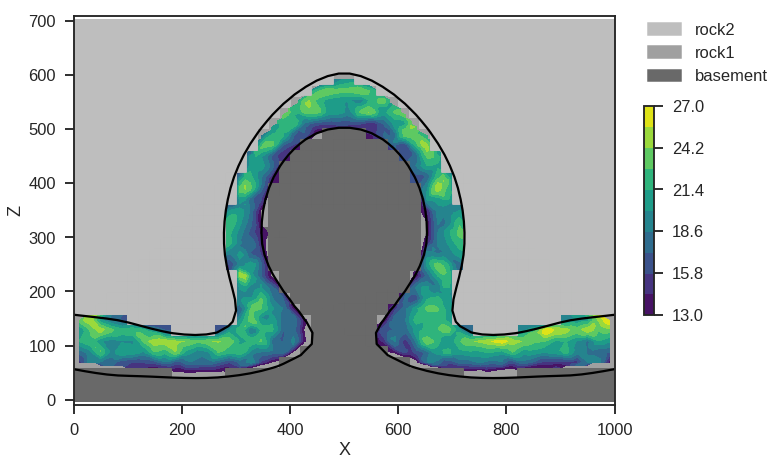

In [82]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=13, vmax=27)
v = np.linspace(13, 27, 11, endpoint=True)

b = plt.scatter(x=coord_aux_aux[:,0], y=coord_aux_aux[:,2], c='#696969', s=90, marker=',',zorder=2)

c = plt.scatter(x=coord_aux_aux2[:,0], y=coord_aux_aux2[:,2], c='#BEBEBE', s=90, marker=',',zorder=2)

a = plt.contourf(X, Y, Z, v, cmap='viridis', zorder=1, norm=norm)

gp.plotting.extract_countours(geo_data, interp_data, cell_number=25,
                         direction='y', fb=fault_block, lb=lith_block)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=25,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(100,600)

plt.colorbar(a, orientation='vertical', fraction=0.018, pad=0.05)

plt.savefig(fname='Dome_ydir_an=100', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  


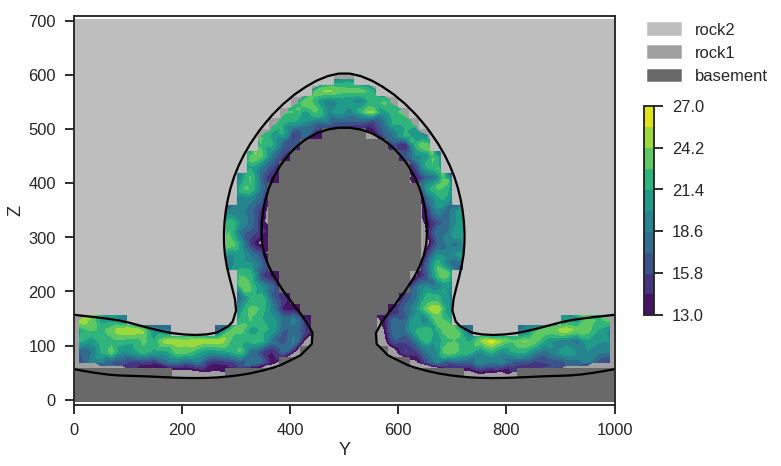

In [83]:
X, Y, Z = grid(combined_cut2[:,0], combined_cut2[:,1], combined_cut2[:,2])

norm=matplotlib.colors.Normalize(vmin=13, vmax=27)
v = np.linspace(13, 27, 11, endpoint=True)

b = plt.scatter(x=coord_aux_aux[:,0], y=coord_aux_aux[:,2], c='#696969', s=90, marker=',',zorder=2)

c = plt.scatter(x=coord_aux_aux2[:,0], y=coord_aux_aux2[:,2], c='#BEBEBE', s=90, marker=',',zorder=2)

a = plt.contourf(X, Y, Z, v, cmap='viridis', zorder=1, norm=norm)

gp.plotting.extract_countours(geo_data, interp_data, cell_number=25,
                         direction='x', fb=fault_block, lb=lith_block)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=25,
                         direction='x', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(100,600)

plt.colorbar(a, orientation='vertical', fraction=0.018, pad=0.05)

plt.savefig(fname='Dome_xdir_an=100_plot', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [62]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               original_scale=True)

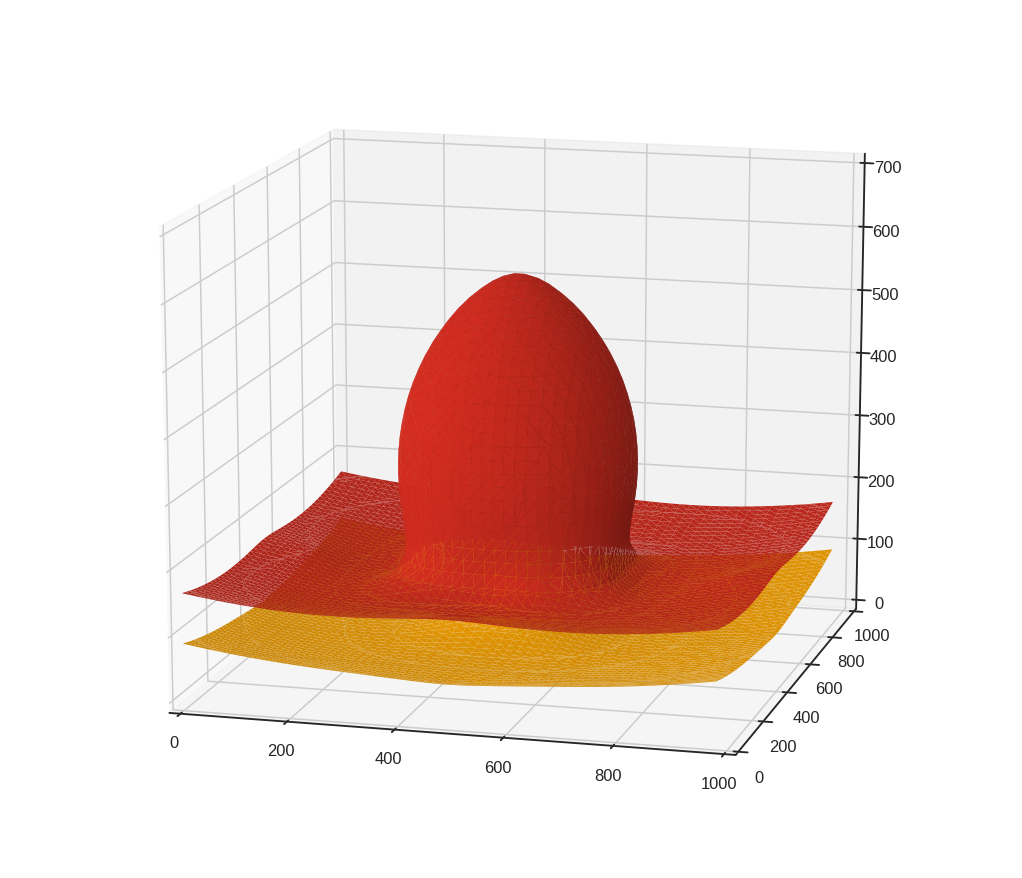

In [68]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

a = ax.plot_trisurf(ver_s[1][:,0],ver_s[1][:,1], ver_s[1][:,2], triangles=sim_s[1], color='#ffa700')
#a = ax.plot_trisurf(ver_s[2][:,0],ver_s[2][:,1], ver_s[2][:,2], triangles=sim_s[2], color='#0057e7')
#a = ax.plot_trisurf(ver_s[3][:,0],ver_s[3][:,1], ver_s[3][:,2], triangles=sim_s[3], color='#d62d20')
#a = ax.plot_trisurf(ver_s[4][:,0],ver_s[4][:,1], ver_s[4][:,2], triangles=sim_s[4], color='#ffa700')
a = ax.plot_trisurf(ver_s[0][:,0],ver_s[0][:,1], ver_s[0][:,2], triangles=sim_s[0], color='#d62d20')

ax.view_init(15, -75)
ax.axes.set_zlim3d(0,700)
ax.axes.set_xlim3d(0,1000)
ax.axes.set_ylim3d(0,1000)
#a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=20, marker=',', cmap='viridis', alpha=1)


#{'basement':'#808080','Sandstone_1':'#ffa700','Shale':'#d62d20','Siltstone':'#0057e7', 'Sandstone_2':'#008744','Main_Fault':'#000000'}


#b = ax.scatter(geo_data.grid.values[:,0], geo_data.grid.values[:,1], geo_data.grid.values[:,2], s=2, c='black')

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

ax.view_init(15, -75)
#fig.colorbar(a, orientation='horizontal')

plt.savefig(fname='3D_GemPy_model_extreme', edgecolor='black', bbox_inches='tight')